# Neural Networks in PyTorch
## Part 7: Binary Classification of Images using a Single-Layer Perceptron
Yen Lee Loh, 2021-9-8, 2022-11-23

In this notebook we examine the MNIST Digits dataset and demonstrate binary classification using a SLP.

---
## 1. Set up and load the MNIST Digits dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn        # import torch.nn as nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
from collections.abc import Iterable
rng = np.random.default_rng()
np.set_printoptions (linewidth=300)
plt.rcParams.update ({'font.family':'monospace', 'font.size':11})
#plt.rcParams.update ({'font.family':'serif', 'font.size':13})


'''
  gallery(xnij)
  Display an array of grayscale images 
'''
def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

def train(xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.001, lossTarget=0.01, reportInterval=1000):
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  model.train()                  # put model in training mode
  for t in range(epochs):      # t is the epoch number
    Ynd = model(xnd)             # uppercase Y = model prediction
    loss = lossFunc(Ynd,ynd)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    F = loss.item()
    if t % reportInterval == 0 or t==epochs:
      print('Training epoch {}/{}\t Loss = {:.4f}'.format(t, epochs, F))
    if F < lossTarget:
      print('Training epoch {}/{}\t Loss = {:.4f} < lossTarget\n'.format(t, epochs, F))
      return
  print ('Warning: loss > lossTarget!\n')
  
def metrics (Yn, yn):   # Yn are model outputs, yn are true outputs
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

In [2]:
#================ DOWNLOAD THE MNIST-TRAIN DATASET, WHICH CONTAINS 60000 HANDWRITTEN DIGITS
dataset = torchvision.datasets.MNIST('MNIST-TRAIN', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=70000, shuffle=False)
iterator = iter(loader)
inputs,outputs = next(iterator)  # new PyTorch syntax; old syntax was iterator.next()
inputs = inputs.squeeze()        # get rid of unnecessary dimension

---
## 2. Examine the MNIST dataset

In [3]:
#================ EXAMINE GLOBAL PROPERTIES OF DATASET
print ("inputs.shape  =", inputs.shape)
print ("outputs.shape =", outputs.shape)
print ("populations of each of 10 classes =", np.bincount (outputs))

inputs.shape  = torch.Size([60000, 28, 28])
outputs.shape = torch.Size([60000])
populations of each of 10 classes = [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


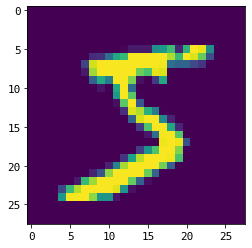

inputs[0]      = 0.01 * 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   7   7   7  49  53  69  10  65 100  97  50   0   0   0   0]
 [  0   0   0   0   0   0   0   0  12  14  37  60  67  99  99  99  99  99  88  67  99  95  76  25   0   0   0   0]
 [  0   0   0   0   0   0   0  19  93  99  99  99  99  99  99  99  99  98  36  32  32  22  15   0   0   0   0   0]
 [  0   0   0   0   0   0   0   7  86  99  99  99  99 

In [4]:
#================ EXAMINE FIRST TRAINING EXAMPLE
plt.imshow (inputs[0]) ; plt.show()
print ("inputs[0]      = 0.01 * \n", np.round(100*np.array(inputs[0])).astype(int) )
print ("outputs[0]     =", outputs[0])

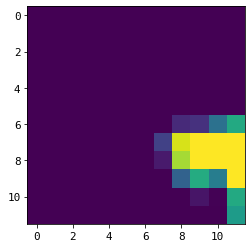

In [12]:
plt.imshow(inputs[0][:12,:12])

In [5]:
#================ PRINT FIRST 10 TRAINING OUTPUTS (LABELS)
print (outputs[:10])

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


Some examples from the MNIST dataset


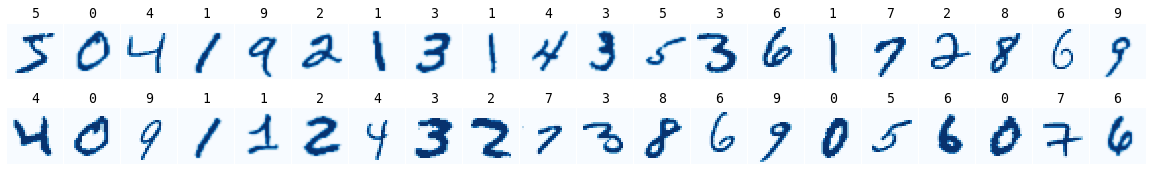

In [6]:
#================ VISUALIZE FIRST 10 TRAINING OUTPUTS (LABELS) AND INPUTS (IMAGES)
print ('Some examples from the MNIST dataset');   gallery(inputs[:40], labels=[y.item() for y in outputs[:40]], cmap='Blues') ; plt.show()

---
## 3. Select two classes for binary classification

Some training examples


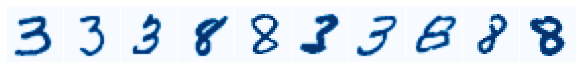

Some validation examples


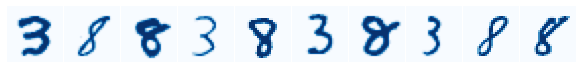

In [5]:
#================ SET USER PARAMETERS
class0,class1 = 3,8      # classes to consider
nmaxT,nmaxV = 1000,1000      # number of examples in training set and validation set

nmaxT0 = nmaxT//2 ; nmaxT1 = nmaxT//2   # equal numbers of 0's and 1's in training set
nmaxV0 = nmaxV//2 ; nmaxV1 = nmaxV//2
#================ SHUFFLE ENTIRE DATASET IN PLACE
def shuffle (inputs, outputs):
  indices = rng.permutation (len(inputs))
  return inputs[indices],outputs[indices]
def select (inputs, outputs, output):
  indices = np.where(outputs==output)[0]
  return inputs[indices],outputs[indices]
inputs,outputs = shuffle (inputs,outputs)
#================ FILTER DATASET TO CONSIDER ONLY TWO CLASSES
inputs0,outputs0 = select (inputs,outputs,class0) ; outputs0 -= class0 ; outputs0 //= (class1-class0)
inputs1,outputs1 = select (inputs,outputs,class1) ; outputs1 -= class0 ; outputs1 //= (class1-class0)
#gallery(inputs0[:10], cmap='Blues') ; plt.show()
#================ SPLIT INTO TRAINING SET AND VALIDATION SET
xnijT = torch.concatenate ([inputs0[:nmaxT0], inputs1[:nmaxT1]])
ynT   = torch.concatenate ([outputs0[:nmaxT0], outputs1[:nmaxT1]]) * 1.0
xnijV = torch.concatenate ([inputs0[-nmaxV0:], inputs1[-nmaxV1:]])
ynV   = torch.concatenate ([outputs0[-nmaxV0:], outputs1[-nmaxV1:]]) * 1.0
#======== SHUFFLE AGAIN
xnijT,ynT = shuffle (xnijT,ynT)
xnijV,ynV = shuffle (xnijV,ynV)
print ('Some training examples');   gallery(xnijT[:10], cmap='Blues') ; plt.show()
print ('Some validation examples'); gallery(xnijV[:10], cmap='Blues') ; plt.show()
#======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS, AND UNFLATTEN OUTPUTS INTO 1-ELEMENT VECTORS
xndT = xnijT.flatten (1,-1) ; yndT = ynT.reshape (-1,1)
xndV = xnijV.flatten (1,-1) ; yndV = ynV.reshape (-1,1)

_,imax,jmax = xnijT.shape
_,dmax = xndT.shape

---
## 4. Examine the two-class dataset

Input (features):     xnd.shape = torch.Size([1000, 784]) 	minmax(xnd) = [0.0, 1.0]
Output (predictions): ynd.shape = torch.Size([1000, 1]) 	minmax(ynd) = [0.0, 1.0]


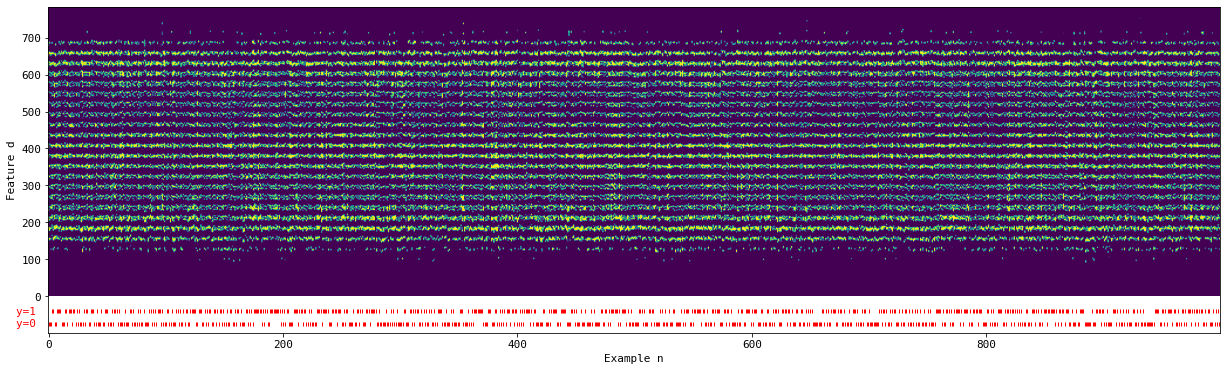

In [6]:
xnd = xndT; ynd = yndT
#xnd = torch.vstack ([xndT,xndV]) ; ynd = torch.vstack ([yndT,yndV])
#======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS
nmax,dmax = xnd.shape
print ("Input (features):     xnd.shape =",xnd.shape,"\tminmax(xnd) =", [xnd.numpy().min(),xnd.numpy().max()] )
print ("Output (predictions): ynd.shape =",ynd.shape,"\tminmax(ynd) =", [ynd.numpy().min(),ynd.numpy().max()] )
#======== VISUALIZE OUR ENTIRE 2000x784 TRAINING DATASET
figure = plt.figure(figsize=(21,6))
plt.imshow (xnd.T, cmap='viridis', aspect='auto'); plt.xlabel ('Example n'); plt.ylabel ('Feature d');
plt.ylim ([-99, 784]); plt.plot (-75+ynd*35,'r|',markersize=4);
plt.text (0,-75,'y=0  ', color='r', va='center', ha='right');
plt.text (0,-40,'y=1  ', color='r', va='center', ha='right');

The heatmap represents training inputs, with pixels (features) $d$ spread out vertically, for each training example $n$.
The red dots represent the training outputs (0 or 1).
It is not easy for a human to distinguish the two classes based on the above picture! Even if the classes are sorted, as below, it is still tricky.

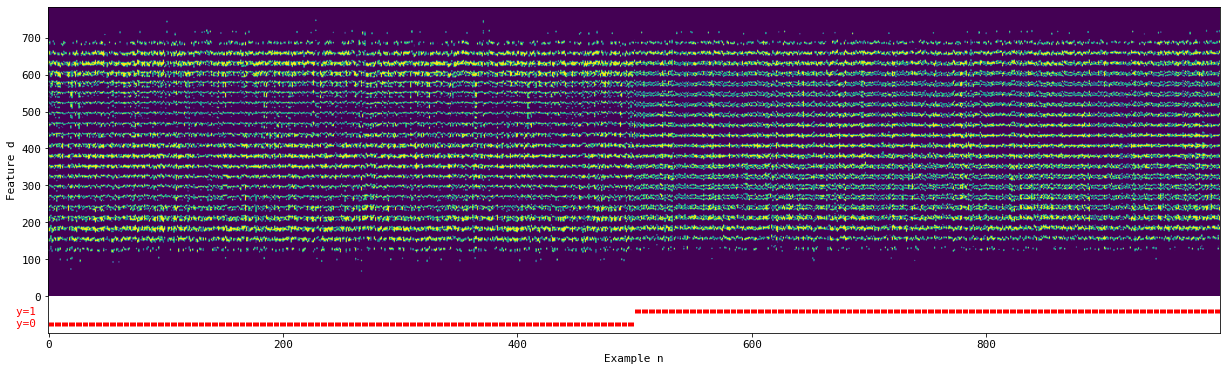

In [79]:
figure = plt.figure(figsize=(21,6))
sortidx = np.argsort (ynd.flatten())
plt.imshow (xnd[sortidx].T, cmap='viridis', aspect='auto'); plt.xlabel ('Example n'); plt.ylabel ('Feature d');
plt.ylim ([-99, 784]); plt.plot (-75+ynd[sortidx]*35,'r|',markersize=4);
plt.text (0,-75,'y=0  ', color='r', va='center', ha='right');
plt.text (0,-40,'y=1  ', color='r', va='center', ha='right');

---
## 5. Train a single-layer perceptron to perform binary classification

In [7]:
#======== TRAIN
model = nn.Sequential(
  nn.Linear(dmax,1), 
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lossHistory = []
model.train()     # choose training mode
for epoch in range(1,20001):
    Ynd = model(xndT)
    loss = lossFunc(Ynd,yndT)
    lossHistory.append (loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 2000 == 0:     print ('Epoch {}    Loss = {:.4f}'.format(epoch, loss.item()))
    if (loss.item() < 0.01): break

Epoch 2000    Loss = 0.0649
Epoch 4000    Loss = 0.0490
Epoch 6000    Loss = 0.0401
Epoch 8000    Loss = 0.0341
Epoch 10000    Loss = 0.0295
Epoch 12000    Loss = 0.0260
Epoch 14000    Loss = 0.0232
Epoch 16000    Loss = 0.0210
Epoch 18000    Loss = 0.0191
Epoch 20000    Loss = 0.0175


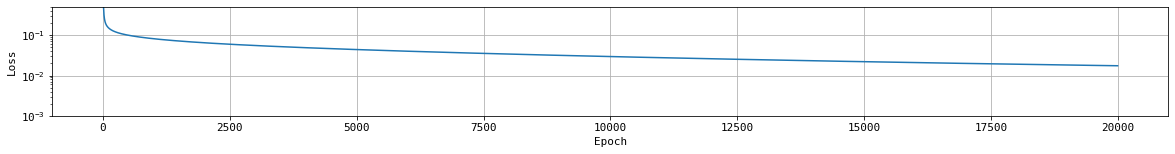

In [8]:
figure = plt.figure(figsize=(20,2))
plt.plot (lossHistory); plt.xlabel ("Epoch"); plt.ylabel ("Loss"); plt.yscale ('log'); plt.ylim ([0.001,0.5]); plt.grid(); 

SLP Weights:


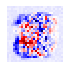

Training Examples:


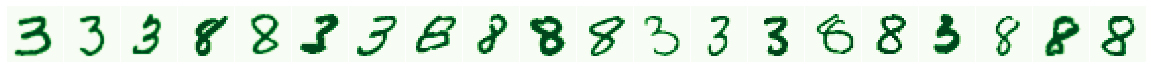

Validation Examples (any misclassified images are shown in red):


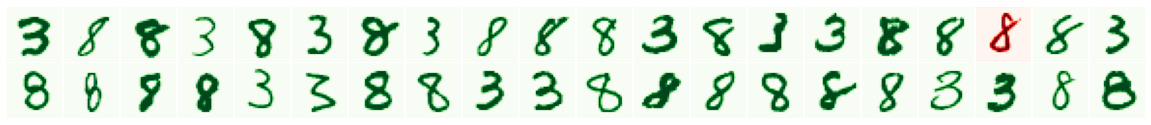

Training error   =    2/1000 =  0.2%    Confusion matrix = [[498, 2], [0, 500]]
Validation error =   46/1000 =  4.6%    Confusion matrix = [[478, 22], [24, 476]]


In [9]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wij  = model[0].weight.detach().numpy().reshape(imax,jmax)
b    = model[0].bias.detach().item()
plt.show() ; print ('SLP Weights:')
gallery ([wij], cmap='seismic', size=1)
#================ DISPLAY SOME IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Examples:')
gallery (xnijT[:20], size=1, cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Examples (any misclassified images are shown in red):')
gallery (xnijV[:40], size=1, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

The above heatmap shows the weights that help the perceptron distinguish between 5's and 6's (or whatever the two digits were).
Note that the validation error might be 5-10% with a SLP, depending on which digits we're looking at.